In [1]:
import numpy as np
import matplotlib as mat
import os
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import scvelo as scv
import multivelo as mv
scv.__version__

Global seed set to 0


'0.3.1'

In [2]:
pip show numpy

Name: numpy
Version: 1.22.0
Summary: NumPy is the fundamental package for array computing with Python.
Home-page: https://www.numpy.org
Author: Travis E. Oliphant et al.
Author-email: 
License: BSD
Location: /pbtech_mounts/homes064/weh4002/anaconda3/envs/multivelo/lib/python3.8/site-packages
Requires: 
Required-by: anndata, chex, contourpy, flax, h5py, jax, jaxlib, loompy, matplotlib, ml-dtypes, mudata, multivelo, numba, numpy-groupies, numpyro, opt-einsum, optax, orbax-checkpoint, pandas, patsy, pyro-ppl, pytorch-lightning, scanpy, scikit-learn, scipy, scvelo, scvi-tools, seaborn, statsmodels, tensorstore, torchmetrics, umap-learn, velocyto
Note: you may need to restart the kernel to use updated packages.


In [3]:
scv.settings.verbosity = 3
scv.settings.presenter_view = True
scv.set_figure_params('scvelo')
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 100)
np.set_printoptions(suppress=True)

In [3]:
#Preprocessing the ATAC 

sampleID = ['Macaque_M1_VIS','Macaque_M2_VIS']
i = 0

for sample in sampleID: 
    i = i+1
    matrix_path = f'/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_{sample}/outs/filtered_feature_bc_matrix/'
    print(f'reading ATAC input from the mtx path : {matrix_path}')
    adata_atac = sc.read_10x_mtx(matrix_path, var_names='gene_symbols', cache=True, gex_only=False)
    adata_atac = adata_atac[:,adata_atac.var['feature_types'] == "Peaks"]
    adata_atac = mv.aggregate_peaks_10x(adata_atac,
                                    f'/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_{sample}/outs/peak_annotation.tsv',
                                    f'/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_{sample}/outs/analysis/feature_linkage/feature_linkage.bedpe',
                                    verbose=True)
    mv.tfidf_norm(adata_atac)
    # subset the annotated cells from ATAC assay 
    cell_anno_path = f'/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/{sample}_celltype_annotation'
    cell_annot = pd.read_csv(cell_anno_path,sep = "\t",index_col=0)
    shared_cells_anno = pd.Index(np.intersect1d(adata_atac.obs_names, cell_annot.index))
    adata_atac = adata_atac[shared_cells_anno,:]
      adata_atac.obs_names = [f'{sample}_' + x for x in adata_atac.obs_names]
    adata_atac.var_names_make_unique()
       if i == 1: adata_atac_all = adata_atac
  
    if i > 1:
        adata_atac_all = adata_atac_all.concatenate(adata_atac)

reading ATAC input from the mtx path : /athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_Macaque_M1_VIS/outs/filtered_feature_bc_matrix/
CellRanger ARC identified as 2.0.0
Found 13272 genes with promoter peaks


  0%|          | 0/13272 [00:00<?, ?it/s]

reading ATAC input from the mtx path : /athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/cellranger/MO_Macaque_M2_VIS/outs/filtered_feature_bc_matrix/
CellRanger ARC identified as 2.0.0
Found 13593 genes with promoter peaks


  0%|          | 0/13593 [00:00<?, ?it/s]

In [4]:
### rename the index (cellid) after concatenation
adata_atac_all.obs_names = [x.split('-')[0][:] + '-1' for x in adata_atac_all.obs_names]

In [5]:
adata_atac_all

AnnData object with n_obs × n_vars = 29343 × 13073
    obs: 'batch'

In [6]:
adata_atac_all.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_adata_ATAC_raw.h5ad')

In [7]:
sampleID = ['Macaque_M1_VIS','Macaque_M2_VIS']

i = 0
for sample in sampleID: 
    i = i+1
    loom_path = f'/athena/tilgnerlab/scratch/weh4002/Multivelo/velocyto/Macaque_controls_loom/{sample}.loom'
    cell_anno_path = f'/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/{sample}_celltype_annotation'
    print(f'loom file path is {loom_path}')
    print(f'cell annotation file path is {cell_anno_path}')
    adata_rna = scv.read(loom_path, cache=True)
    adata_rna.obs_names = [x.split(':')[1][:-1] + '-1' for x in adata_rna.obs_names]
    cell_annot = pd.read_csv(cell_anno_path,sep = "\t",index_col=0)
    ## subset annotated cells from RNA assay
    shared_cells_anno = pd.Index(np.intersect1d(adata_rna.obs_names, cell_annot.index))
    adata_rna = adata_rna[shared_cells_anno,:]
    ## assign celltypes
    adata_rna.obs['celltype'] = cell_annot['celltype']
    ### rename cells with sampleID
    adata_rna.obs_names = [f'{sample}_' + x for x in adata_rna.obs_names]
    adata_rna.var_names_make_unique()
       if i == 1: adata_rna_all = adata_rna
   
    if i > 1:
        adata_rna_all = adata_rna_all.concatenate(adata_rna)


loom file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/velocyto/Macaque_controls_loom/Macaque_M1_VIS.loom
cell annotation file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_M1_VIS_celltype_annotation
loom file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/velocyto/Macaque_controls_loom/Macaque_M2_VIS.loom
cell annotation file path is /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_M2_VIS_celltype_annotation


In [8]:
### rename the index (cellid) after concatenation
adata_rna_all.obs_names = [x.split('-')[0][:] + '-1' for x in adata_rna_all.obs_names]

In [10]:
adata_rna_all

AnnData object with n_obs × n_vars = 29343 × 34884
    obs: 'celltype', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [11]:
adata_rna_all.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_adata_RNA_raw.h5ad')

In [12]:
scv.pp.filter_and_normalize(adata_rna_all, min_shared_counts=10)

Filtered out 24567 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Logarithmized X.


/home/weh4002/anaconda3/envs/multivelo/lib/python3.8/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)


In [13]:
adata_rna_all

AnnData object with n_obs × n_vars = 29343 × 10317
    obs: 'celltype', 'batch', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'gene_count_corr'
    uns: 'log1p'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [14]:
shared_cells = pd.Index(np.intersect1d(adata_rna_all.obs_names, adata_atac_all.obs_names))
shared_genes_assay = pd.Index(np.intersect1d(adata_rna_all.var_names, adata_atac_all.var_names))

In [15]:
len(shared_cells), len(shared_genes_assay)

(29343, 8905)

In [16]:
shared_genes_assay

Index(['AAAS', 'AACS', 'AADAT', 'AAGAB', 'AAK1', 'AAMDC', 'AAMP', 'AAR2',
       'AARS1', 'AARS2',
       ...
       'ZSWIM7', 'ZSWIM8', 'ZUP1', 'ZW10', 'ZWILCH', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', length=8905)

In [17]:
## import the genes tested for dPSI
PSI_genes = pd.Index(pd.read_csv("/athena/tilgnerlab/scratch/weh4002/Macaque_3controls_MO/delta_PSI_PFCvsVIS/Macaque_broad_Celltypes_deltaPSI_tested_GeneNames.txt", header=None)[0])

In [18]:
PSI_genes

Index(['AAK1', 'AATK', 'ABAT', 'ABCA5', 'ABCC10', 'ABCE1', 'ABCF3', 'ABHD12',
       'ABHD6', 'ABI1',
       ...
       'ZNF414', 'ZNF484', 'ZNF532', 'ZNF568', 'ZNF638', 'ZNF711', 'ZRANB3',
       'ZSWIM7', 'ZYX', 'ensembl'],
      dtype='object', name=0, length=1571)

In [19]:
## find the shared genes between RNA-ATAC assays and dPSI tested genes
shared_genes = pd.Index(np.intersect1d(shared_genes_assay, PSI_genes))

In [47]:
shared_genes

Index(['AAK1', 'AATK', 'ABAT', 'ABCA5', 'ABCC10', 'ABCE1', 'ABCF3', 'ABHD12',
       'ABHD6', 'ABI1',
       ...
       'ZNF37A', 'ZNF410', 'ZNF414', 'ZNF484', 'ZNF568', 'ZNF638', 'ZNF711',
       'ZRANB3', 'ZSWIM7', 'ZYX'],
      dtype='object', length=1421)

In [21]:
adata_rna_all = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_adata_RNA_raw.h5ad')

In [22]:
adata_rna_all

AnnData object with n_obs × n_vars = 29343 × 34884
    obs: 'celltype', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [23]:
## subset the shared_cells and shared_genes from whole assay
adata_rna = adata_rna_all[shared_cells, shared_genes]

In [24]:
adata_rna

View of AnnData object with n_obs × n_vars = 29343 × 1421
    obs: 'celltype', 'batch'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [25]:
adata_rna.var_names_make_unique()

In [26]:
scv.pp.normalize_per_cell(adata_rna)
scv.pp.log1p(adata_rna)

Normalized count data: X, spliced, unspliced.


/tmp/ipykernel_56859/2089892543.py:2: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  scv.pp.log1p(adata_rna)


In [27]:
scv.pp.moments(adata_rna, n_pcs=30, n_neighbors=50)

computing neighbors
    finished (0:00:28) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:05) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


In [28]:
adata_rna.obs['celltype'] = adata_rna.obs['celltype'].astype('category')

In [29]:
set(adata_rna.obs['celltype'])

{'Astrocytes',
 'Endothelial',
 'Excitatory_Neurons',
 'Inhibitory_Neurons',
 'Microglia',
 'OPCs',
 'Oligodendrocytes'}

In [30]:
adata_rna = adata_rna[adata_rna.obs['celltype'].isin(['Astrocytes',
                                                      'Excitatory_Neurons',
                                                      'Inhibitory_Neurons',
                                                      'Microglia',
                                                      'Oligodendrocytes',
                                                      'OPCs'])]

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_spliced.unpliced_proportions_dPSIgenes.pdf


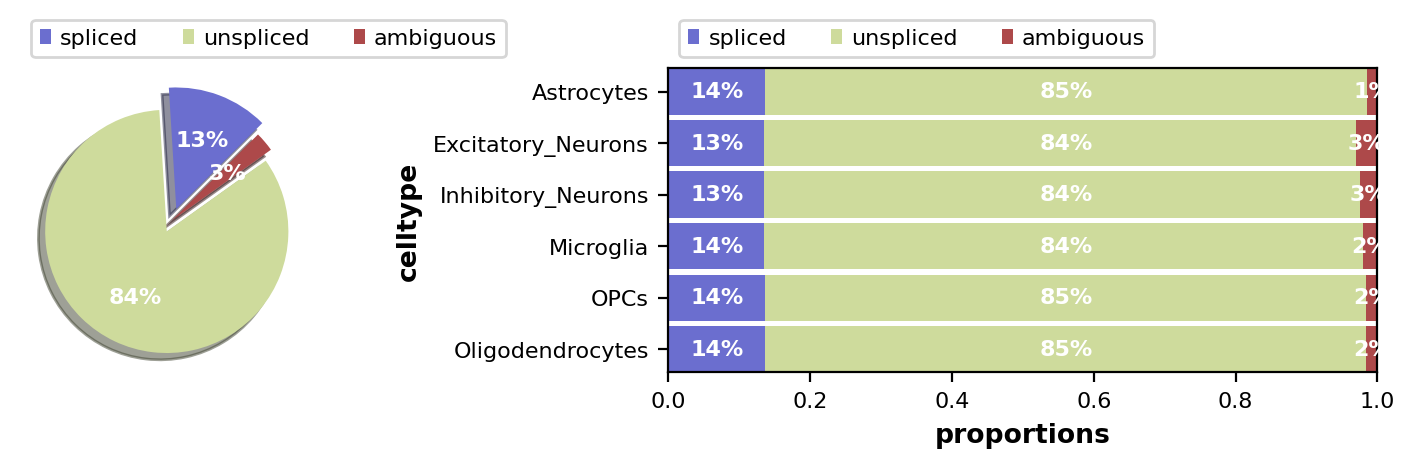

In [31]:
scv.pl.proportions(adata_rna, groupby='celltype',save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_spliced.unpliced_proportions_dPSIgenes.pdf' )

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_adata_rna_umap_dPSI_genes.pdf


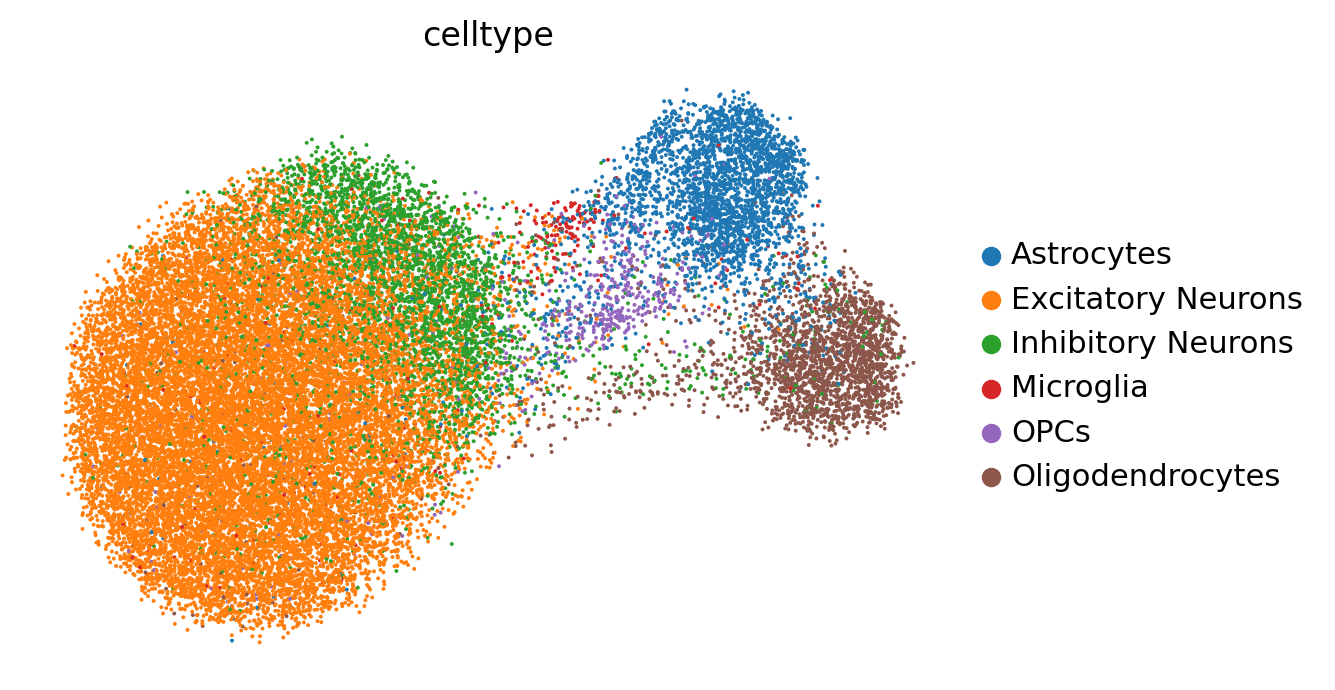

In [32]:
scv.tl.umap(adata_rna)
scv.pl.umap(adata_rna, color='celltype',size = 8, legend_loc='right margin',save = "/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_adata_rna_umap_dPSI_genes.pdf")

In [33]:
adata_rna.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_adata_rna.dPSIgenes.celltype.filtered_normalized.h5ad')

In [48]:
adata_atac

AnnData object with n_obs × n_vars = 14458 × 13593

In [49]:
# Read in Seurat WNN neighbors.
nn_idx = np.loadtxt("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_filtered_cells/Macaque_merge_wnn_files/Macaque_VIS_nn_idx.txt", delimiter=',')
nn_dist = np.loadtxt("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_filtered_cells/Macaque_merge_wnn_files/Macaque_VIS_nn_dist.txt", delimiter=',')
nn_cells = pd.Index(pd.read_csv("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_filtered_cells/Macaque_merge_wnn_files/Macaque_VIS_nn_cells.txt", header=None)[0])

In [50]:
adata_atac_all.obs_names

Index(['Macaque_M1_VIS_AAACAGCCAAACCTAT-1',
       'Macaque_M1_VIS_AAACAGCCAAAGGCCA-1',
       'Macaque_M1_VIS_AAACAGCCAATAACCT-1',
       'Macaque_M1_VIS_AAACAGCCAATTAGGA-1',
       'Macaque_M1_VIS_AAACAGCCACAACCTA-1',
       'Macaque_M1_VIS_AAACAGCCACATTAAC-1',
       'Macaque_M1_VIS_AAACAGCCACCAACCG-1',
       'Macaque_M1_VIS_AAACAGCCACGGTACT-1',
       'Macaque_M1_VIS_AAACAGCCAGCAATAA-1',
       'Macaque_M1_VIS_AAACAGCCAGGCCATT-1',
       ...
       'Macaque_M2_VIS_TTTGTTGGTAATAACC-1',
       'Macaque_M2_VIS_TTTGTTGGTGGGTACT-1',
       'Macaque_M2_VIS_TTTGTTGGTGGTTCTT-1',
       'Macaque_M2_VIS_TTTGTTGGTGTGAGGA-1',
       'Macaque_M2_VIS_TTTGTTGGTGTTTGAG-1',
       'Macaque_M2_VIS_TTTGTTGGTTAGACCA-1',
       'Macaque_M2_VIS_TTTGTTGGTTATTGCC-1',
       'Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1',
       'Macaque_M2_VIS_TTTGTTGGTTGCACGG-1',
       'Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1'],
      dtype='object', length=29343)

In [51]:
np.all(nn_cells == adata_atac_all.obs_names)

True

In [52]:
adata_atac_all

AnnData object with n_obs × n_vars = 29343 × 13073
    obs: 'batch'

In [53]:
mv.knn_smooth_chrom(adata_atac_all, nn_idx, nn_dist)

In [54]:
shared_cells_new = pd.Index(np.intersect1d(adata_rna.obs_names, adata_atac_all.obs_names))

In [55]:
shared_cells_new

Index(['Macaque_M1_VIS_AAACAGCCAAACCTAT-1',
       'Macaque_M1_VIS_AAACAGCCAAAGGCCA-1',
       'Macaque_M1_VIS_AAACAGCCAATAACCT-1',
       'Macaque_M1_VIS_AAACAGCCAATTAGGA-1',
       'Macaque_M1_VIS_AAACAGCCACAACCTA-1',
       'Macaque_M1_VIS_AAACAGCCACATTAAC-1',
       'Macaque_M1_VIS_AAACAGCCACCAACCG-1',
       'Macaque_M1_VIS_AAACAGCCACGGTACT-1',
       'Macaque_M1_VIS_AAACAGCCAGCAATAA-1',
       'Macaque_M1_VIS_AAACAGCCAGGCCATT-1',
       ...
       'Macaque_M2_VIS_TTTGTTGGTAATAACC-1',
       'Macaque_M2_VIS_TTTGTTGGTGGGTACT-1',
       'Macaque_M2_VIS_TTTGTTGGTGGTTCTT-1',
       'Macaque_M2_VIS_TTTGTTGGTGTGAGGA-1',
       'Macaque_M2_VIS_TTTGTTGGTGTTTGAG-1',
       'Macaque_M2_VIS_TTTGTTGGTTAGACCA-1',
       'Macaque_M2_VIS_TTTGTTGGTTATTGCC-1',
       'Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1',
       'Macaque_M2_VIS_TTTGTTGGTTGCACGG-1',
       'Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1'],
      dtype='object', length=28422)

In [56]:
adata_atac = adata_atac_all[shared_cells_new, shared_genes]

In [57]:
adata_atac.write('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_adata_atac.dPSIgenes.celltype.filtered_knn.smooth.h5ad')

In [4]:
adata_atac = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_adata_atac.dPSIgenes.celltype.filtered_knn.smooth.h5ad')

In [5]:
adata_rna = sc.read_h5ad('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_adata_rna.dPSIgenes.celltype.filtered_normalized.h5ad')

In [6]:
adata_rna

AnnData object with n_obs × n_vars = 28422 × 1421
    obs: 'celltype', 'batch', 'n_counts'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand'
    uns: 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'Ms', 'Mu', 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances'

In [7]:
adata_atac

AnnData object with n_obs × n_vars = 28422 × 1421
    obs: 'batch'
    layers: 'Mc'
    obsp: 'connectivities'

In [8]:
# This will take a while. Parallelization is high recommended.
#mv.settings.VERBOSITY = 0
adata_result = mv.recover_dynamics_chrom(adata_rna,
                                         adata_atac,
                                         max_iter=5,
                                         init_mode="invert",
                                         parallel=True,
                                         save_plot=False,
                                         rna_only=False,
                                         fit=True,
                                         n_anchors=500,
                                         extra_color_key='celltype'
                                        )

  0%|          | 0/1421 [00:00<?, ?it/s]

Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed set to 0
Global seed s

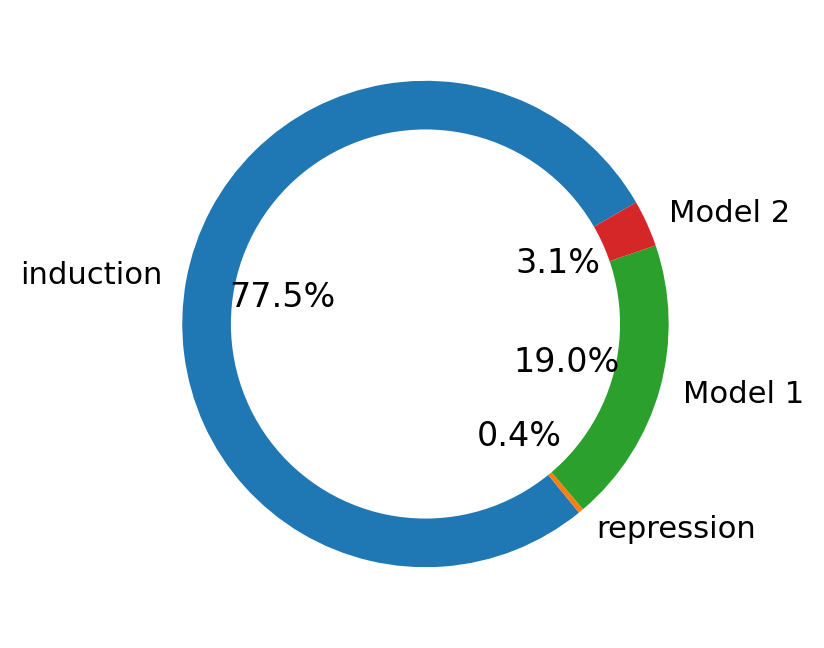

In [9]:
mv.pie_summary(adata_result)

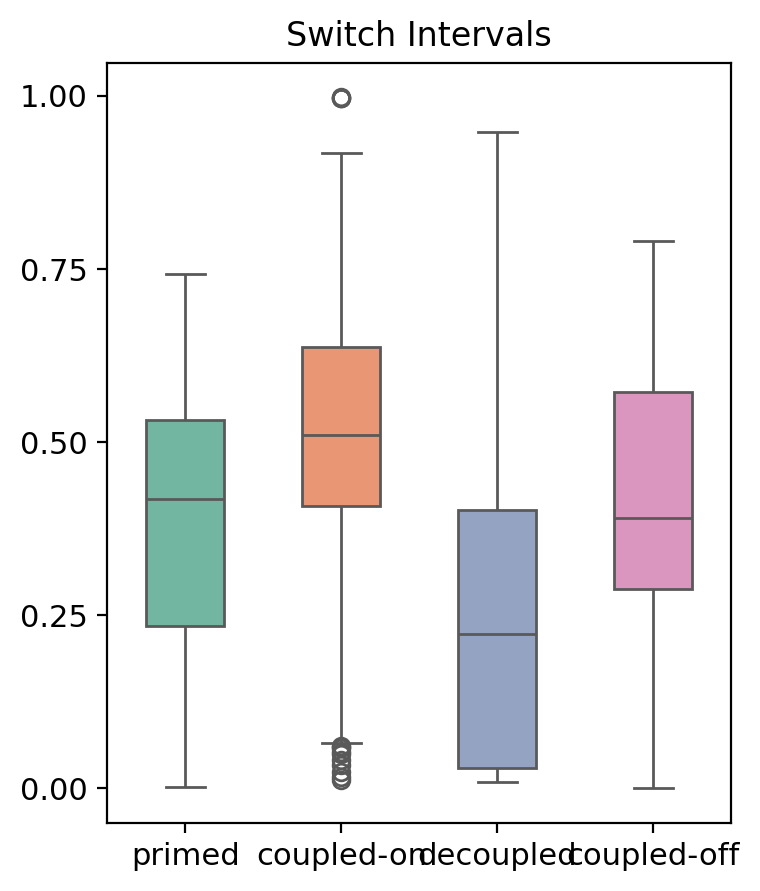

In [11]:
mv.switch_time_summary(adata_result)

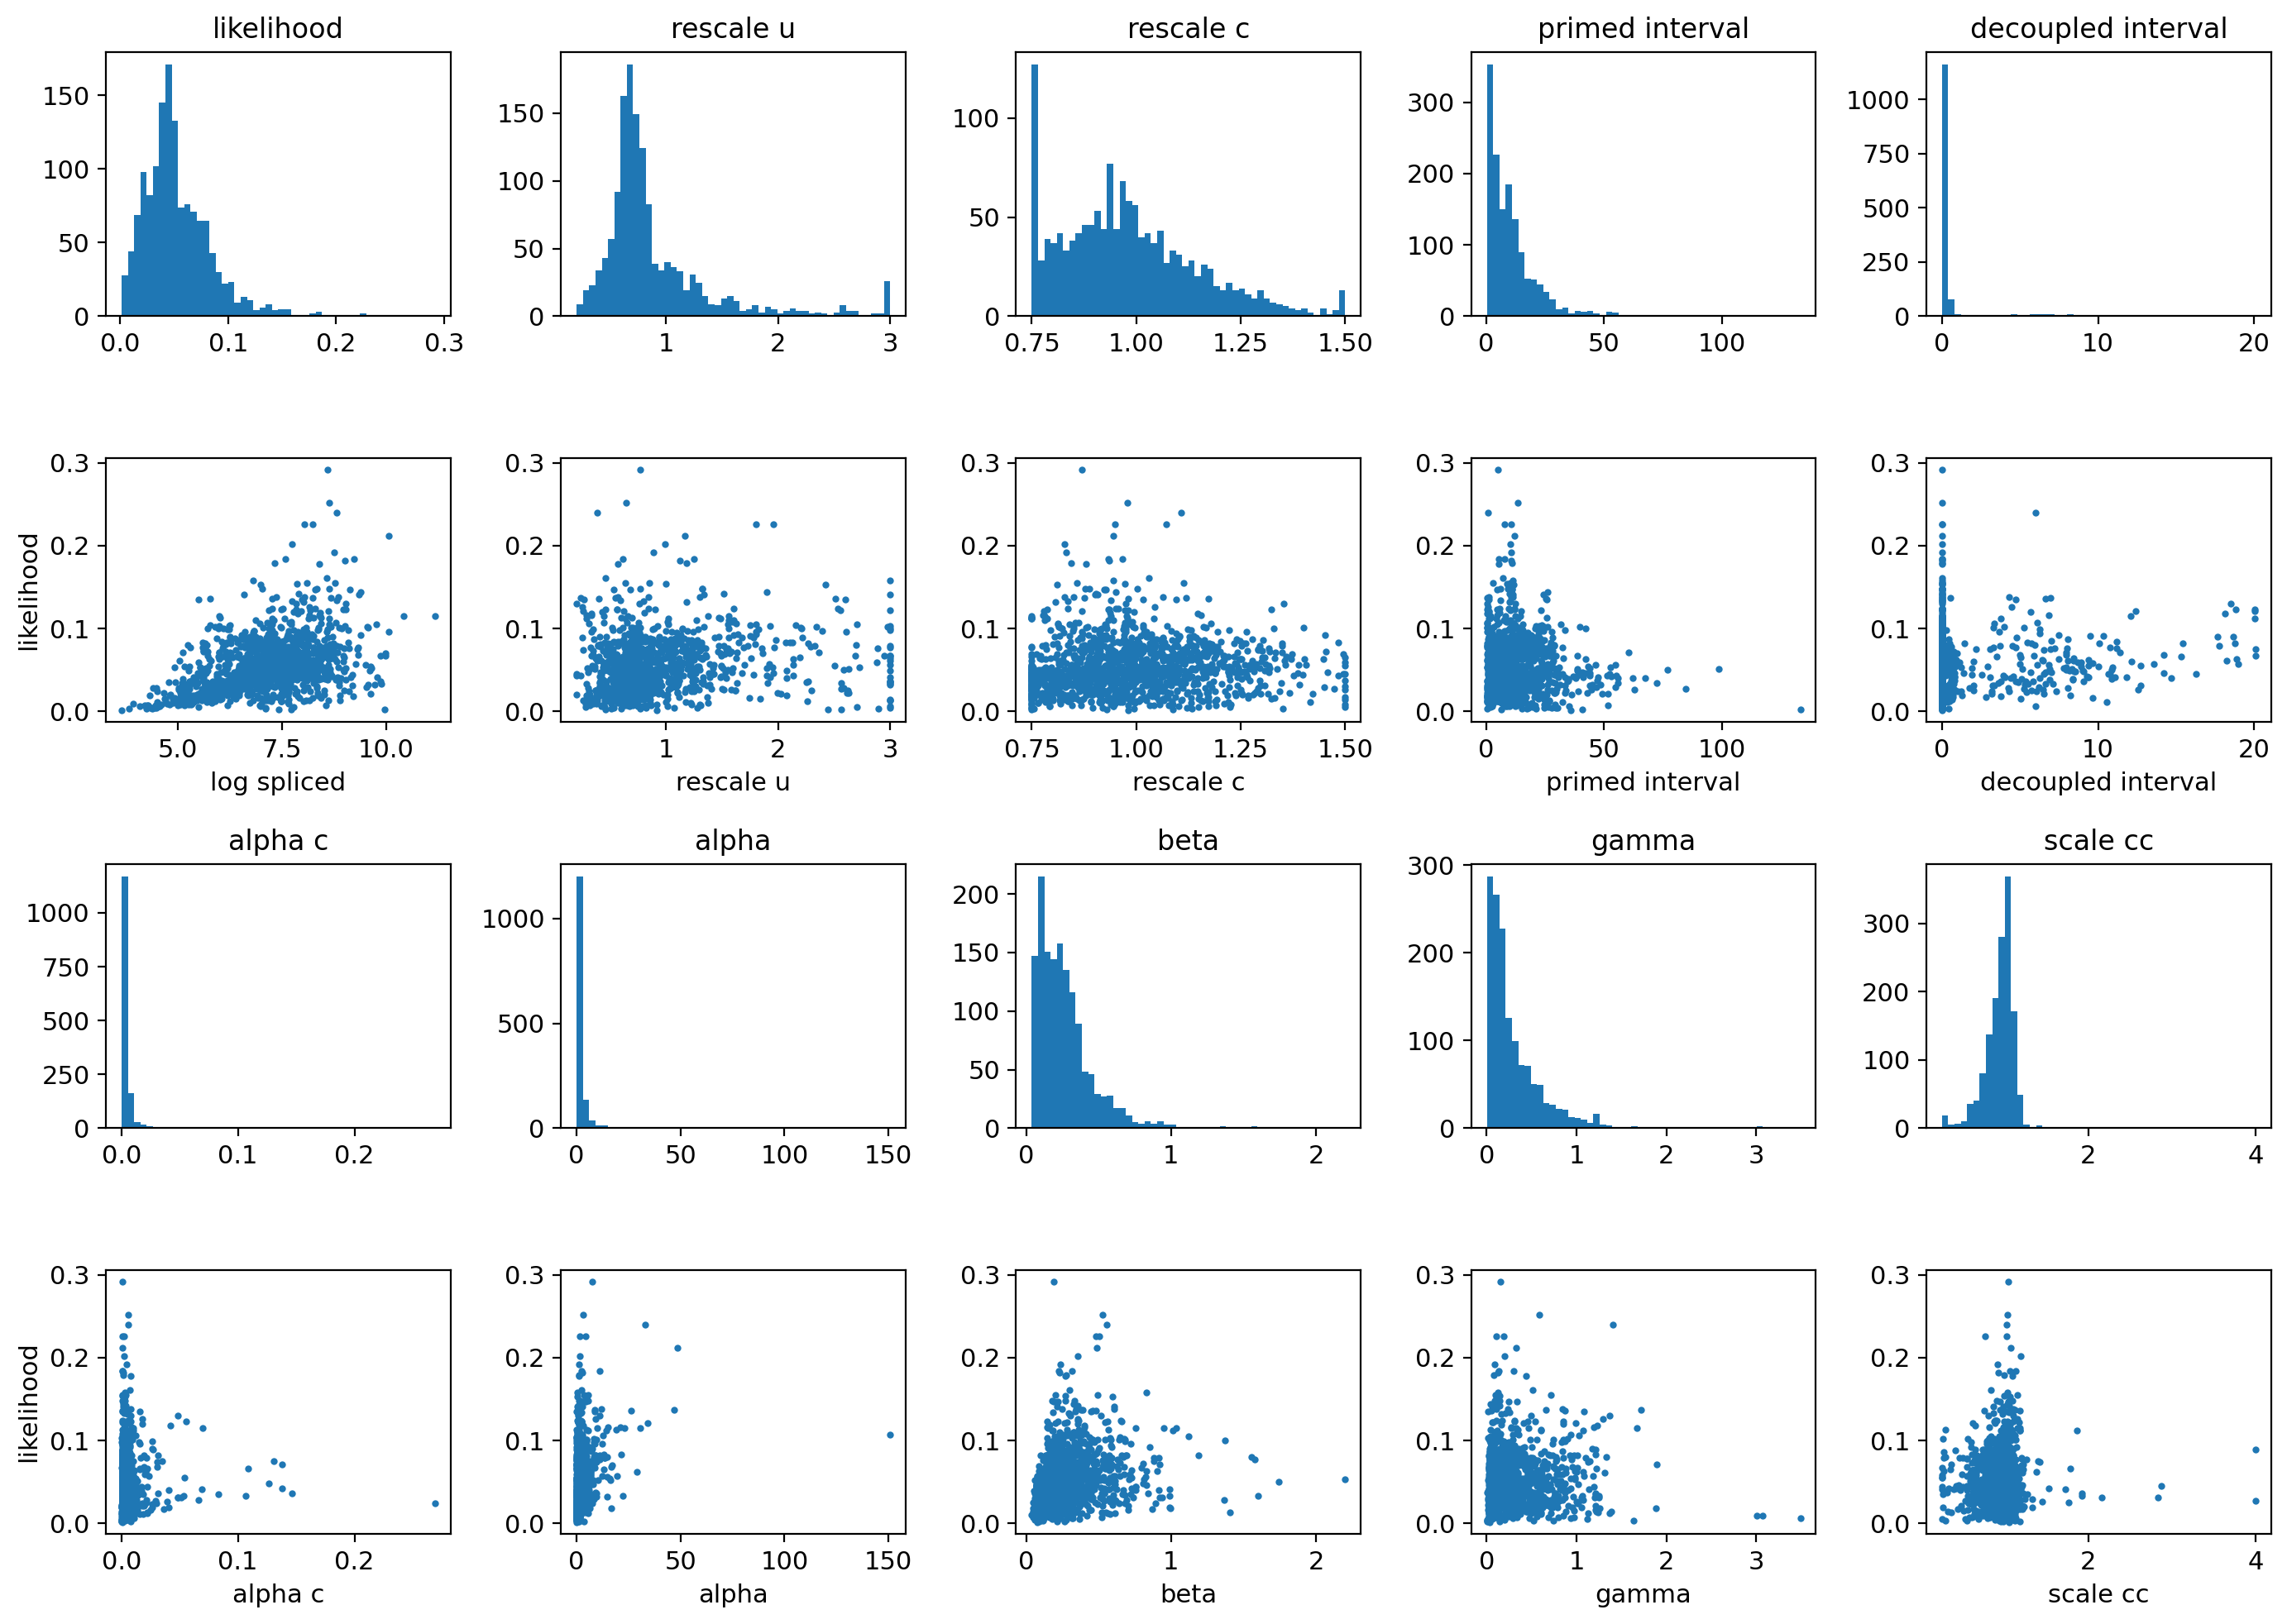

In [12]:
mv.likelihood_plot(adata_result)

In [13]:
#Computing velocity stream and latent time
mv.velocity_graph(adata_result)
mv.latent_time(adata_result)

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing velocity graph (using 1/56 cores)


  0%|          | 0/28422 [00:00<?, ?cells/s]

    finished (0:00:20) --> added 
    'velo_s_norm_graph', sparse matrix with cosine correlations (adata.uns)
or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
computing terminal states
    identified 9 regions of root cells and 3 regions of end points .
    finished (0:00:02) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing latent time using root_cells as prior
    finished (0:00:04) --> added 
    'latent_time', shared time (adata.obs)


computing velocity embedding
    finished (0:00:08) --> added
    'velo_s_norm_umap', embedded velocity vectors (adata.obsm)
figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_velocity_stream_dPSItested_genes.png


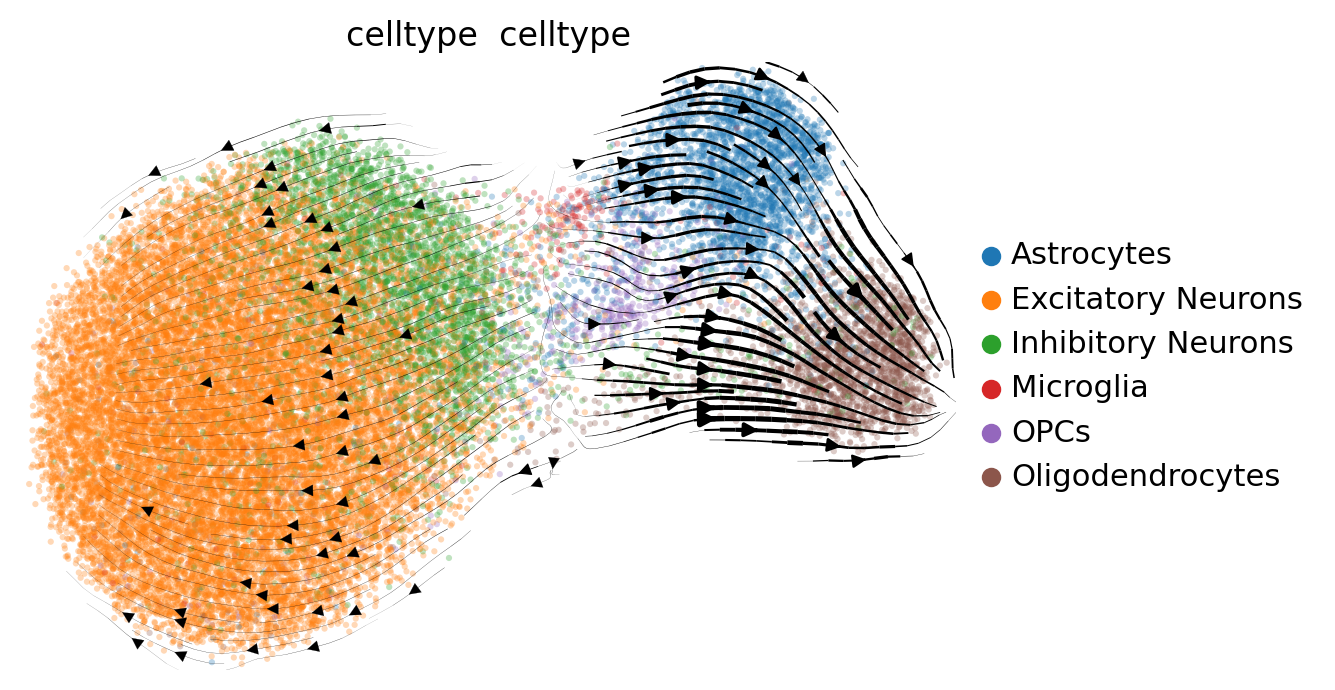

In [14]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='celltype',size = 20, legend_loc='right margin',layer='celltype', save = '/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_velocity_stream_dPSItested_genes.pdf')

In [15]:
### add sampleID 
adata_result.obs['IndividualID'] = [x.split('_')[1][:] for x in adata_result.obs_names]
adata_result.obs['Region'] = [x.split('_')[2][:] for x in adata_result.obs_names]
#adata_result.obs['SampleID'] = f'adata_result.obs['IndividualID']_adata_result.obs['Region']'

In [16]:
adata_result.obs['SampleID'] = adata_result.obs['IndividualID'].astype(str) + adata_result.obs['Region']

In [17]:
adata_result.obs

celltype batch    n_counts  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1    Oligodendrocytes     0  106.999985   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1  Excitatory_Neurons     0  107.000015   
Macaque_M1_VIS_AAACAGCCAATAACCT-1  Excitatory_Neurons     0  107.000000   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1  Inhibitory_Neurons     0  106.999992   
Macaque_M1_VIS_AAACAGCCACAACCTA-1          Astrocytes     0  106.999992   
...                                               ...   ...         ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1  Excitatory_Neurons     1  107.000000   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1  Inhibitory_Neurons     1  107.000015   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1          Astrocytes     1  106.999992   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1  Excitatory_Neurons     1  106.999992   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1  Excitatory_Neurons     1  106.999992   

                                   velo_s_norm_self_transition  root_cells  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1                     0.000000    0.019031   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1                     0.399288    0.439102   
Macaque_M1_VIS_AAACAGCCAATAACCT-1                     0.435941    0.002743   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1                     0.383108    0.000514   
Macaque_M1_VIS_AAACAGCCACAACCTA-1                     0.000000    0.084143   
...                                                        ...         ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1                     0.395024    0.005522   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1                     0.335283    0.014983   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1                     0.153399    0.243093   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1                     0.370745    0.004799   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1                     0.341361    0.008214   

                                   end_points  velo_s_norm_pseudotime  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1    0.026829                0.191214   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1    0.425433                0.969477   
Macaque_M1_VIS_AAACAGCCAATAACCT-1    0.491975                0.971042   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1    1.000000                0.990687   
Macaque_M1_VIS_AAACAGCCACAACCTA-1    0.012592                0.411991   
...                                       ...                     ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1    0.448969                0.913944   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1    0.049123                0.934165   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1    0.060695                0.444952   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1    0.433168                0.987492   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1    0.342204                0.939429   

                                   latent_time IndividualID Region SampleID  
Macaque_M1_VIS_AAACAGCCAAACCTAT-1     0.041058           M1    VIS    M1VIS  
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1     0.938371           M1    VIS    M1VIS  
Macaque_M1_VIS_AAACAGCCAATAACCT-1     0.947475           M1    VIS    M1VIS  
Macaque_M1_VIS_AAACAGCCAATTAGGA-1     0.922333           M1    VIS    M1VIS  
Macaque_M1_VIS_AAACAGCCACAACCTA-1     0.134678           M1    VIS    M1VIS  
...                                        ...          ...    ...      ...  
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1     0.876382           M2    VIS    M2VIS  
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1     0.762683           M2    VIS    M2VIS  
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1     0.106600           M2    VIS    M2VIS  
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1     0.902520           M2    VIS    M2VIS  
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1     0.943648           M2    VIS    M2VIS  

[28422 rows x 11 columns]

figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_velocity_stream_dPSItested_genes_bySampleID.png


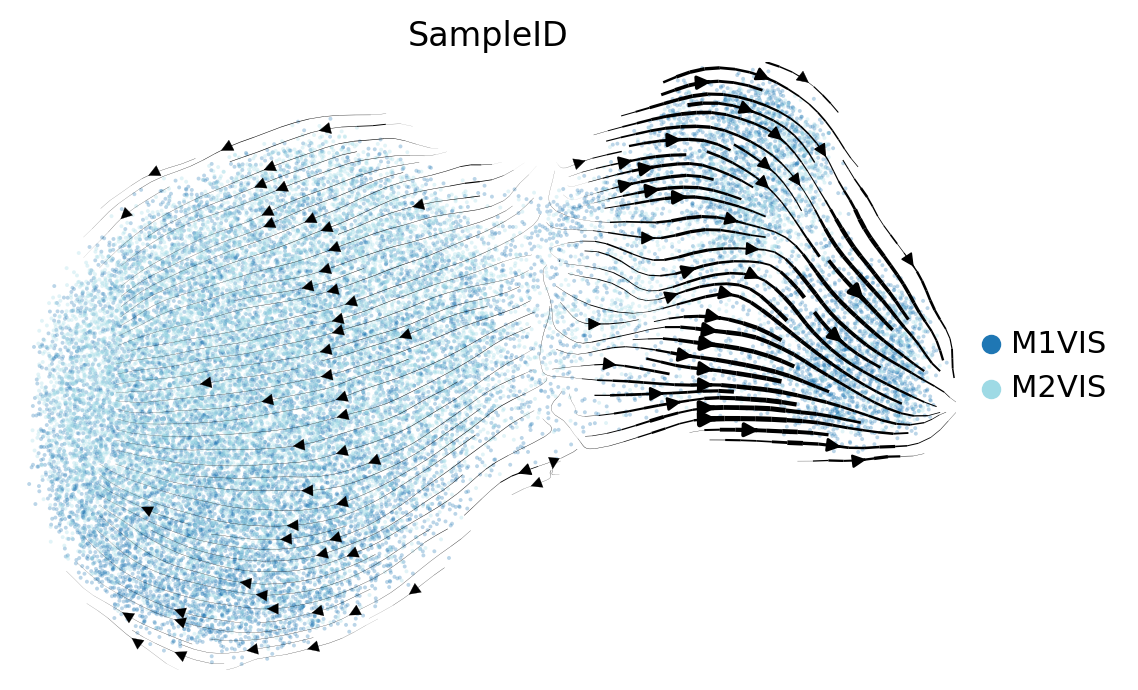

In [18]:
mv.velocity_embedding_stream(adata_result, basis='umap', color='SampleID',palette='tab20',colorbar=True, size = 8, legend_loc='right margin',save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_velocity_stream_dPSItested_genes_bySampleID.pdf')

or is corrupted (e.g. due to subsetting). Consider recomputing with `pp.neighbors`.
        Consider computing the graph in an unbiased manner 
        on full expression space by not specifying basis.

computing velocity graph (using 1/56 cores)


  0%|          | 0/28422 [00:00<?, ?cells/s]

    finished (0:00:19) --> added 
    'velo_chrom_norm_graph', sparse matrix with cosine correlations (adata.uns)
computing velocity embedding
    finished (0:00:08) --> added
    'velo_chrom_norm_umap', embedded velocity vectors (adata.obsm)


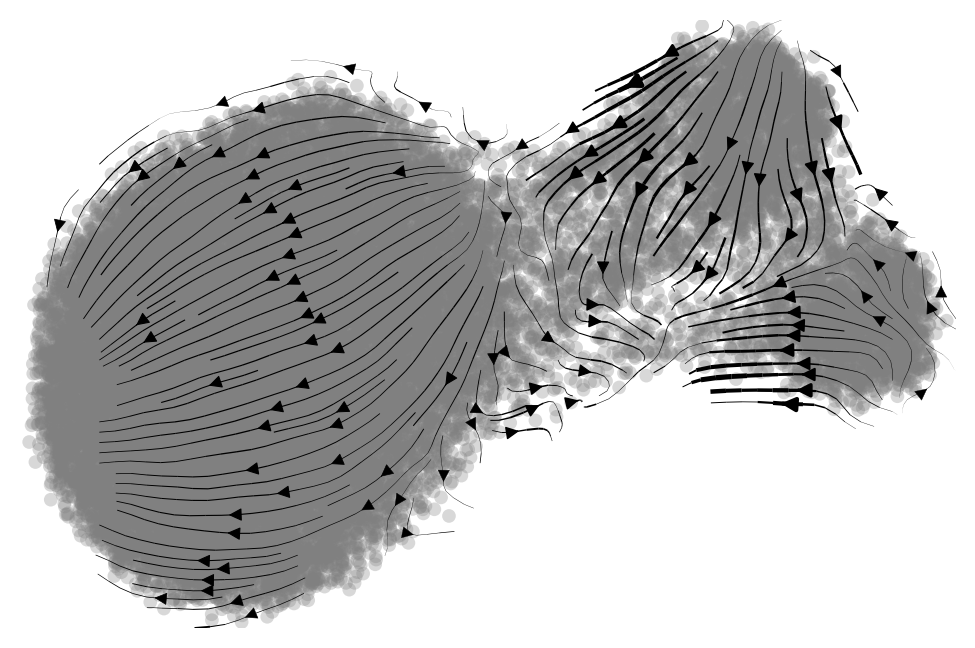

In [19]:
# velocity by atac
mv.velocity_embedding_stream(adata_result, basis='umap',vkey='velo_chrom')

figure cannot be saved as pdf, using png instead (can only output finite numbers in pdf).
saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_ATAC_velocity_stream_dPSItested_genes_byCelltype.png


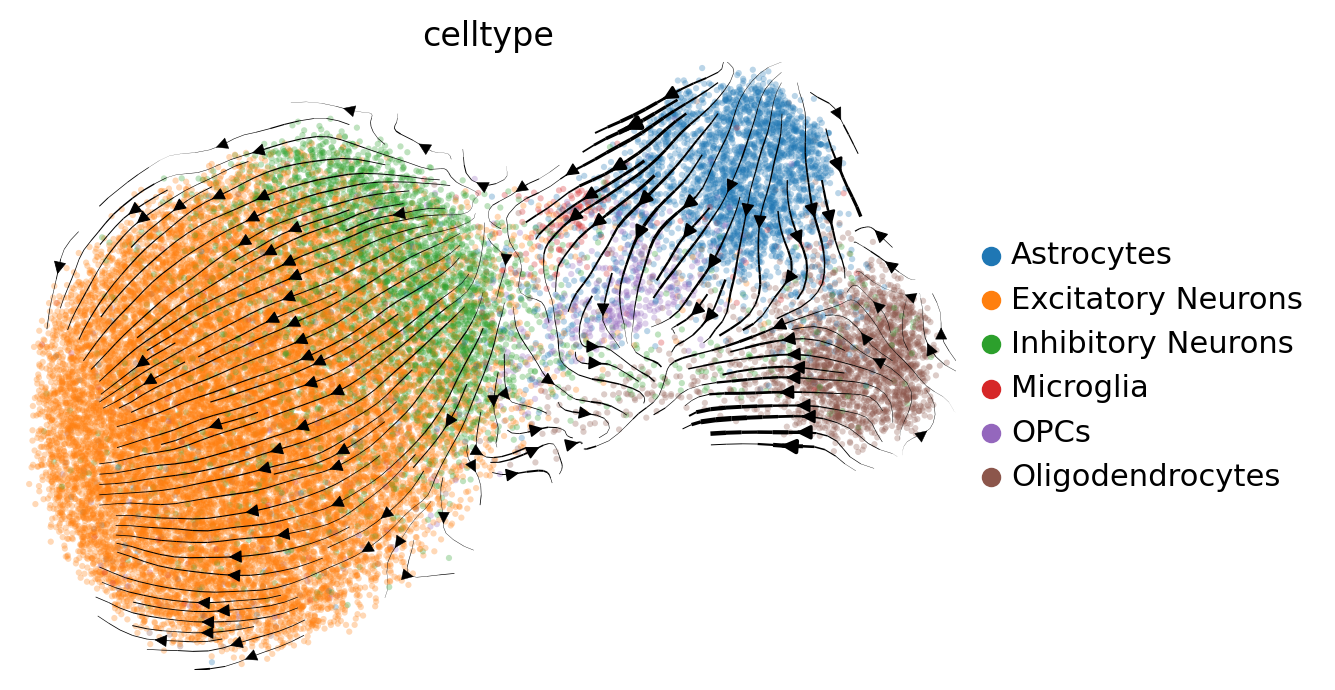

In [20]:
# plot velocity stream by velo_chrom
mv.velocity_embedding_stream(adata_result,color='celltype',size = 20, legend_loc='right margin', basis='umap',vkey='velo_chrom',save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_ATAC_velocity_stream_dPSItested_genes_byCelltype.pdf')

saving figure to file /athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_latentTime.pdf


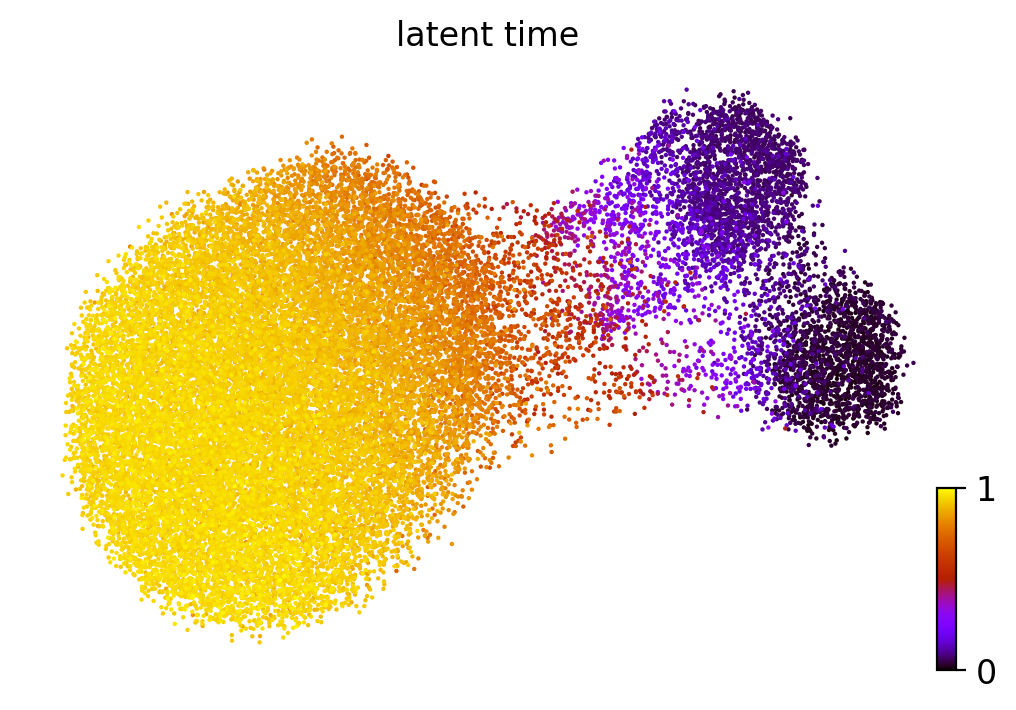

In [21]:
scv.pl.scatter(adata_result, color='latent_time', color_map='gnuplot', size=10,save='/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_latentTime.pdf')

In [22]:
# Save the result for use later on
adata_result.write("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_dPSItestedGenes.h5ad")

In [3]:
adata_result=sc.read_h5ad("/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_dPSItestedGenes.h5ad")

In [4]:
adata_result

AnnData object with n_obs × n_vars = 28422 × 1420
    obs: 'celltype', 'batch', 'n_counts', 'velo_s_norm_self_transition', 'root_cells', 'end_points', 'velo_s_norm_pseudotime', 'latent_time', 'IndividualID', 'Region', 'SampleID', 'velo_chrom_norm_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_alpha_c', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_sw1', 'fit_t_sw2', 'fit_t_sw3', 'fit_scale_cc', 'fit_rescale_c', 'fit_rescale_u', 'fit_alignment_scaling', 'fit_model', 'fit_direction', 'fit_loss', 'fit_likelihood', 'fit_likelihood_c', 'fit_ssd_c', 'fit_var_c', 'fit_c0', 'fit_u0', 'fit_s0', 'fit_anchor_min_idx', 'fit_anchor_max_idx', 'fit_anchor_velo_min_idx', 'fit_anchor_velo_max_idx', 'velo_s_genes', 'velo_u_genes', 'velo_chrom_genes', 'velo_s_norm_genes', 'velo_chrom_norm_genes'
    uns: 'SampleID_colors', 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap', 'velo_chrom_norm_graph', 'velo_chrom_norm_graph_neg', 'velo_chrom_norm_params', 'velo_chrom_

In [5]:
adata_result.obs

celltype batch    n_counts  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1    Oligodendrocytes     0  106.999985   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1  Excitatory_Neurons     0  107.000015   
Macaque_M1_VIS_AAACAGCCAATAACCT-1  Excitatory_Neurons     0  107.000000   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1  Inhibitory_Neurons     0  106.999992   
Macaque_M1_VIS_AAACAGCCACAACCTA-1          Astrocytes     0  106.999992   
...                                               ...   ...         ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1  Excitatory_Neurons     1  107.000000   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1  Inhibitory_Neurons     1  107.000015   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1          Astrocytes     1  106.999992   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1  Excitatory_Neurons     1  106.999992   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1  Excitatory_Neurons     1  106.999992   

                                   velo_s_norm_self_transition  root_cells  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1                     0.000000    0.019031   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1                     0.399288    0.439102   
Macaque_M1_VIS_AAACAGCCAATAACCT-1                     0.435941    0.002743   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1                     0.383108    0.000514   
Macaque_M1_VIS_AAACAGCCACAACCTA-1                     0.000000    0.084143   
...                                                        ...         ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1                     0.395024    0.005522   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1                     0.335283    0.014983   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1                     0.153399    0.243093   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1                     0.370745    0.004799   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1                     0.341361    0.008214   

                                   end_points  velo_s_norm_pseudotime  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1    0.026829                0.191214   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1    0.425433                0.969477   
Macaque_M1_VIS_AAACAGCCAATAACCT-1    0.491975                0.971042   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1    1.000000                0.990687   
Macaque_M1_VIS_AAACAGCCACAACCTA-1    0.012592                0.411991   
...                                       ...                     ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1    0.448969                0.913944   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1    0.049123                0.934165   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1    0.060695                0.444952   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1    0.433168                0.987492   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1    0.342204                0.939429   

                                   latent_time IndividualID Region SampleID  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1     0.041058           M1    VIS    M1VIS   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1     0.938371           M1    VIS    M1VIS   
Macaque_M1_VIS_AAACAGCCAATAACCT-1     0.947475           M1    VIS    M1VIS   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1     0.922333           M1    VIS    M1VIS   
Macaque_M1_VIS_AAACAGCCACAACCTA-1     0.134678           M1    VIS    M1VIS   
...                                        ...          ...    ...      ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1     0.876382           M2    VIS    M2VIS   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1     0.762683           M2    VIS    M2VIS   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1     0.106600           M2    VIS    M2VIS   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1     0.902520           M2    VIS    M2VIS   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1     0.943648           M2    VIS    M2VIS   

                                   velo_chrom_norm_self_transition  
Macaque_M1_VIS_AAACAGCCAAACCTAT-1                         0.085268  
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1                         0.041329  
Macaque_M1_VIS_AAACAGCCAATAACCT-1                         0.098459  
Macaque_M1_VIS_AAACAGCCAATTAGGA-1                         0.051993  
Macaque_M1_VIS_AAACAGCCACAACCTA-1   

In [9]:
adata_result_exn = adata_result[adata_result.obs['celltype'] == "Excitatory_Neurons"]

In [13]:
adata_result_exn

View of AnnData object with n_obs × n_vars = 18577 × 1420
    obs: 'celltype', 'batch', 'n_counts', 'velo_s_norm_self_transition', 'root_cells', 'end_points', 'velo_s_norm_pseudotime', 'latent_time', 'IndividualID', 'Region', 'SampleID', 'velo_chrom_norm_self_transition'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'fit_alpha_c', 'fit_alpha', 'fit_beta', 'fit_gamma', 'fit_t_sw1', 'fit_t_sw2', 'fit_t_sw3', 'fit_scale_cc', 'fit_rescale_c', 'fit_rescale_u', 'fit_alignment_scaling', 'fit_model', 'fit_direction', 'fit_loss', 'fit_likelihood', 'fit_likelihood_c', 'fit_ssd_c', 'fit_var_c', 'fit_c0', 'fit_u0', 'fit_s0', 'fit_anchor_min_idx', 'fit_anchor_max_idx', 'fit_anchor_velo_min_idx', 'fit_anchor_velo_max_idx', 'velo_s_genes', 'velo_u_genes', 'velo_chrom_genes', 'velo_s_norm_genes', 'velo_chrom_norm_genes'
    uns: 'SampleID_colors', 'celltype_colors', 'log1p', 'neighbors', 'pca', 'umap', 'velo_chrom_norm_graph', 'velo_chrom_norm_graph_neg', 'velo_chrom_norm_params', 'vel

In [14]:
exn_cells = adata_result_exn.obs.index
dPSI_filter_genes = adata_result.var.index
state_exn = adata_result[exn_cells,dPSI_filter_genes].layers['fit_state']
state_exn_df = pd.DataFrame(state_exn)

In [17]:
state_exn_df.index = exn_cells
state_exn_df.columns = dPSI_filter_genes

In [22]:
state_exn_df

Gene                               AAK1  AATK  ABAT  ABCA5  ABCC10  ABCE1  \
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M1_VIS_AAACAGCCAATAACCT-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M1_VIS_AAACAGCCACATTAAC-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M1_VIS_AAACAGCCACCAACCG-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M1_VIS_AAACAGCCAGCAATAA-1   1.0   1.0   1.0    1.0     1.0    2.0   
...                                 ...   ...   ...    ...     ...    ...   
Macaque_M2_VIS_TTTGTTGGTGGTTCTT-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M2_VIS_TTTGTTGGTGTGAGGA-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1   1.0   1.0   1.0    1.0     1.0    2.0   

Gene                               ABCF3  ABHD12  ABHD6  ABI1  ...  ZNF37A  \
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1    1.0     1.0    3.0   1.0  ...     1.0   
Macaque_M1_VIS_AAACAGCCAATAACCT-1    1.0     1.0    3.0   1.0  ...     1.0   
Macaque_M1_VIS_AAACAGCCACATTAAC-1    1.0     1.0    3.0   3.0  ...     1.0   
Macaque_M1_VIS_AAACAGCCACCAACCG-1    1.0     1.0    3.0   1.0  ...     1.0   
Macaque_M1_VIS_AAACAGCCAGCAATAA-1    1.0     1.0    3.0   1.0  ...     1.0   
...                                  ...     ...    ...   ...  ...     ...   
Macaque_M2_VIS_TTTGTTGGTGGTTCTT-1    1.0     1.0    3.0   1.0  ...     1.0   
Macaque_M2_VIS_TTTGTTGGTGTGAGGA-1    1.0     1.0    3.0   1.0  ...     1.0   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1    1.0     1.0    3.0   1.0  ...     1.0   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1    1.0     1.0    1.0   1.0  ...     1.0   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1    1.0     1.0    3.0   1.0  ...     1.0   

Gene                               ZNF410  ZNF414  ZNF484  ZNF568  ZNF638  \
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1     1.0     1.0     1.0     1.0     2.0   
Macaque_M1_VIS_AAACAGCCAATAACCT-1     1.0     1.0     1.0     1.0     2.0   
Macaque_M1_VIS_AAACAGCCACATTAAC-1     1.0     1.0     1.0     1.0     2.0   
Macaque_M1_VIS_AAACAGCCACCAACCG-1     1.0     1.0     1.0     1.0     2.0   
Macaque_M1_VIS_AAACAGCCAGCAATAA-1     1.0     1.0     1.0     1.0     2.0   
...                                   ...     ...     ...     ...     ...   
Macaque_M2_VIS_TTTGTTGGTGGTTCTT-1     1.0     1.0     1.0     1.0     2.0   
Macaque_M2_VIS_TTTGTTGGTGTGAGGA-1     1.0     1.0     1.0     1.0     2.0   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1     1.0     1.0     1.0     1.0     2.0   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1     1.0     1.0     1.0     1.0     2.0   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1     1.0     1.0     1.0     1.0     2.0   

Gene                               ZNF711  ZRANB3  ZSWIM7  ZYX  
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1     1.0     1.0     1.0  1.0  
Macaque_M1_VIS_AAACAGCCAATAACCT-1     1.0     1.0     1.0  1.0  
Macaque_M1_VIS_AAACAGCCACATTAAC-1     1.0     1.0     1.0  1.0  
Macaque_M1_VIS_AAACAGCCACCAACCG-1     1.0     1.0     1.0  1.0  
Macaque_M1_VIS_AAACAGCCAGCAATAA-1     1.0     1.0     1.0  1.0  
...                                   ...     ...     ...  ...  
Macaque_M2_VIS_TTTGTTGGTGGTTCTT-1     1.0     1.0     1.0  1.0  
Macaque_M2_VIS_TTTGTTGGTGTGAGGA-1     1.0     1.0     1.0  1.0  
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1     1.0     1.0     1.0  1.0  
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1     1.0     1.0     1.0  1.0  
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1     1.0     1.0     1.0  1.0  

[18577 rows x 1420 columns]

In [23]:
# save the state matrix, index = cellID, header = geneName
state_exn_df.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_species.comparison_dPSItestedGenes_ExN_Cell_States_mtx.csv')

In [21]:
adata_result[:,'ABHD6'].layers['fit_state']

ArrayView([[2.],
           [3.],
           [3.],
           ...,
           [3.],
           [1.],
           [3.]])

In [23]:
unique_fit_model = set(adata_result.var['fit_model'])

In [24]:
# get the model 1 genes
adata1 = adata_result[:, adata_result.var['fit_model'].values == 1]
# get the model 2 genes
adata2 = adata_result[:, adata_result.var['fit_model'].values == 2]

In [25]:
adata1.var

Accession Chromosome        End      Start Strand  \
Gene                                                                 
AAK1    ENSMMUG00000007868         13   39340248   39160062      +   
AATK    ENSMMUG00000015514         16   77499815   77452417      -   
ABAT    ENSMMUG00000046237         20    8825602    8716480      +   
ABCA5   ENSMMUG00000018608         16   65636081   65557549      -   
ABCC10  ENSMMUG00000015569          4  125904949  125858539      -   
...                    ...        ...        ...        ...    ...   
ZNF568  ENSMMUG00000043883         19   36332431   36299450      +   
ZNF711  ENSMMUG00000013603          X   82141545   82116221      +   
ZRANB3  ENSMMUG00000000765         12   20679677   20375415      -   
ZSWIM7  ENSMMUG00000030294         16   16420666   16398382      +   
ZYX     ENSMMUG00000012635          3  169986921  169975486      +   

        fit_alpha_c  fit_alpha  fit_beta  fit_gamma  fit_t_sw1  fit_t_sw2  \
Gene                                                                        
AAK1       0.001751   1.894858  0.144680   0.116059  -0.053417  20.083179   
AATK       0.003835   1.190451  0.188079   0.092324  -0.019707  20.020433   
ABAT       0.002697   0.702821  0.157773   0.183627  -0.278346  20.036234   
ABCA5      0.003511   2.251879  0.207210   0.361878  -0.008903  20.002922   
ABCC10     0.001167   1.947570  0.227829   0.201271  -0.012387  20.034812   
...             ...        ...       ...        ...        ...        ...   
ZNF568     0.000983   0.193394  0.207768   0.045287  -0.061838  20.012419   
ZNF711     0.000890   0.674453  0.185734   0.040960   7.716301  20.018319   
ZRANB3     0.002005   0.164618  0.072893   0.333634  -0.080813  20.144901   
ZSWIM7     0.002573   0.087671  0.162231   0.043147  -0.070124  20.062086   
ZYX        0.003405   0.450639  0.212450   0.064288  -0.065663  20.049929   

        fit_t_sw3  fit_scale_cc  fit_rescale_c  fit_rescale_u  \
Gene                                                            
AAK1    23.257919      1.014915       0.850665       1.027298   
AATK    21.679389      1.185467       0.762776       0.943254   
ABAT    52.857143      0.860282       0.934368       0.645719   
ABCA5   22.447761      1.048868       1.012115       0.479052   
ABCC10  21.081081      0.986770       1.080291       0.610963   
...           ...           ...            ...            ...   
ZNF568  23.267327      0.986964       1.177954       1.494199   
ZNF711  22.113402      0.951111       1.166543       0.808426   
ZRANB3  66.060606      1.134581       0.758039       0.631835   
ZSWIM7  22.597403      1.033163       0.935488       0.946627   
ZYX     21.578947      1.025261       0.876784       0.554045   

        fit_alignment_scaling  fit_model fit_direction  fit_loss  \
Gene                                                               
AAK1                 2.257919        1.0            on  0.023496   
AATK                 1.904580        1.0            on  0.021150   
ABAT                 2.741758        1.0            on  0.001449   
ABCA5                1.489552        1.0            on  0.005485   
ABCC10               1.348649        1.0            on  0.035630   
...                       ...        ...           ...       ...   
ZNF568               2.470297        1.0            on  0.025953   
ZNF711               1.286082        1.0            on  0.038765   
ZRANB3               5.040404        1.0            on  0.000443   
ZSWIM7               2.160173        1.0            on  0.000150   
ZYX                  1.641447        1.0            on  0.006356   

        fit_likelihood  fit_likelihood_c     fit_ssd_c  fit_var_c    fit_c0  \
Gene                                                                          
AAK1          0.076454          0.272915  20049.118686   0.786076  0.032005   
AATK          0.042701          0.233183  10920.802875   1.074806  0.046533   
ABAT          0.048386          0.271835  16360.285979   

In [26]:
adata2.var

Accession Chromosome        End      Start Strand  \
Gene                                                                   
ADD1      ENSMMUG00000008379          5    3043742    2947716      +   
ADGRB2    ENSMMUG00000023401          1  192944149  192905685      +   
ALCAM     ENSMMUG00000009107          2  170819749  170612796      -   
APC       ENSMMUG00000000330          6  110371282  110225908      +   
ASPH      ENSMMUG00000008777          8   62297070   62075334      -   
ATP8A1    ENSMMUG00000017733          5   41876224   41610342      -   
BIN1      ENSMMUG00000000376         12    3851166    3791633      +   
CAMK2G    ENSMMUG00000021393          9   63992320   63930764      +   
CCDC88A   ENSMMUG00000003003         13   53355247   53216406      +   
CHD4      ENSMMUG00000018685         11    6760312    6721782      -   
CLASP2    ENSMMUG00000031438          2   14220473   14001388      +   
CSNK1A1   ENSMMUG00000001758          6  147065769  147007414      -   
CTTNBP2   ENSMMUG00000010297          3  144073879  143908862      -   
DICER1    ENSMMUG00000023305          7  157344488  157273038      -   
DNM3      ENSMMUG00000007273          1   29716078   29151567      +   
ERLEC1    ENSMMUG00000010640         13   54951553   54857391      -   
EXOC1     ENSMMUG00000023427          5   77752674   77698813      -   
GABRD     ENSMMUG00000019086          1  222413548  222395448      -   
HMGN3     ENSMMUG00000004351          4   93862492   93830364      +   
HNRNPD    ENSMMUG00000060484          5   51372445   51351315      +   
IFFO1     ENSMMUG00000018681         11    6707083    6691061      -   
IGSF8     ENSMMUG00000031542          1   90848956   90837477      +   
INF2      ENSMMUG00000016552          7  167048109  167018325      +   
INPP5F    ENSMMUG00000009558          9  120312835  120210486      +   
KMT2C     ENSMMUG00000007212          3  178416046  178110975      -   
MAN2A1    ENSMMUG00000003316          6  107327080  107151862      +   
MAP4K5    ENSMMUG00000020550          7  112737644  112630532      -   
MBNL1     ENSMMUG00000015910          2   54725860   54462946      +   
MBNL2     ENSMMUG00000022744         17   79153250   78981233      +   
MPHOSPH8  ENSMMUG00000016475         17    1365192    1327359      -   
NAP1L4    ENSMMUG00000007753         14    3053731    3004116      -   
NDRG2     ENSMMUG00000020747          7   82925305   82907307      -   
NDRG4     ENSMMUG00000014618         20   45763655   45709848      +   
NRCAM     ENSMMUG00000021293          3  134776434  134471422      -   
PHLDB1    ENSMMUG00000046655         14  111735079  111682785      +   
PICALM    ENSMMUG00000019618         14   79308787   79193831      -   
PLEKHA1   ENSMMUG00000013040          9  122900922  122843703      +   
PTGES3    ENSMMUG00000013766         11   56266258   56240082      -   
PTPRA     ENSMMUG00000005878         10   63630220   63459645      -   
SH3GL3    ENSMMUG00000013669          7   62244820   62078085      -   
SPAG9     ENSMMUG00000022528         16   45832008   45668845      +   
SULT4A1   ENSMMUG00000005252         10    7649766    7612249      +   
SV2A      ENSMMUG00000007257          1  101269764  101255503      +   
TAOK3     ENSMMUG00000005099         11  118123887  117898814      -   
TMEM25    ENSMMUG00000005492         14  111602619  111597675      +   
UBE2D3    ENSMMUG00000011201          5  101267687  101193287      -   
WNK1      ENSMMUG00000018650         11     912106     755719      +   
ZFYVE16   ENSMMUG00000023177          6   77275006   77211090      +   
ZNF638    ENSMMUG00000007175         13   37515040   37361042      -   

          fit_alpha_c  fit_alpha  fit_beta  fit_gamma  fit_t_sw1  fit_t_sw2  \
Gene                                                                          
ADD1         0.001671   4.871414  0.361436   0.344875  -3.089886  20.032851   
ADGRB2       0.006744   4.578487  0.831382   0.650517  -0.036298   5.776645   
ALCAM        0.003272   7.5791

In [27]:
adata1.obs.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_module1_genes_major.celltypes_dPSItestedGenes_cells.txt', header=True, index=True)
adata1.var.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_module1_genes_major.celltypes_dPSItestedGenes_variable_genes.txt', header=True, index=True)

In [28]:
adata2.obs.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_module2_genes_major.celltypes_dPSItestedGenes_cells.txt', header=True, index=True)
adata2.var.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_module2_genes_major.celltypes_dPSItestedGenes_variable_genes.txt', header=True, index=True)

In [29]:
all_cells = adata_result.obs.index

In [30]:
dPSI_filter_genes = adata_result.var.index

In [31]:
all_cells = adata_result.obs.index
dPSI_filter_genes = adata_result.var.index
state_all = adata_result[:,dPSI_filter_genes].layers['fit_state']
state_all_df = pd.DataFrame(state_all)

In [32]:
state_all_df.index = all_cells
state_all_df.columns = dPSI_filter_genes

In [33]:
state_all_df

Gene                               AAK1  AATK  ABAT  ABCA5  ABCC10  ABCE1  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M1_VIS_AAACAGCCAATAACCT-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M1_VIS_AAACAGCCACAACCTA-1   1.0   1.0   1.0    1.0     1.0    2.0   
...                                 ...   ...   ...    ...     ...    ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1   1.0   1.0   1.0    1.0     1.0    2.0   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1   1.0   1.0   1.0    1.0     1.0    2.0   

Gene                               ABCF3  ABHD12  ABHD6  ABI1  ABI2  ABL2  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1    1.0     1.0    2.0   1.0   1.0   1.0   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1    1.0     1.0    3.0   1.0   1.0   1.0   
Macaque_M1_VIS_AAACAGCCAATAACCT-1    1.0     1.0    3.0   1.0   1.0   1.0   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1    1.0     1.0    3.0   1.0   1.0   1.0   
Macaque_M1_VIS_AAACAGCCACAACCTA-1    1.0     1.0    2.0   1.0   1.0   1.0   
...                                  ...     ...    ...   ...   ...   ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1    1.0     1.0    3.0   1.0   1.0   1.0   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1    1.0     1.0    3.0   1.0   1.0   1.0   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1    1.0     1.0    3.0   3.0   1.0   1.0   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1    1.0     1.0    1.0   1.0   1.0   1.0   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1    1.0     1.0    3.0   1.0   1.0   1.0   

Gene                               ABLIM1  ABLIM2  ABR  ACAA1  ACAD10  ACADSB  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1     1.0     1.0  1.0    1.0     3.0     1.0   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1     1.0     1.0  1.0    1.0     3.0     1.0   
Macaque_M1_VIS_AAACAGCCAATAACCT-1     1.0     1.0  1.0    1.0     3.0     1.0   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1     1.0     1.0  1.0    1.0     3.0     1.0   
Macaque_M1_VIS_AAACAGCCACAACCTA-1     1.0     1.0  1.0    1.0     2.0     1.0   
...                                   ...     ...  ...    ...     ...     ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1     1.0     1.0  1.0    1.0     3.0     1.0   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1     1.0     1.0  1.0    1.0     3.0     1.0   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1     3.0     1.0  1.0    1.0     2.0     1.0   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1     1.0     1.0  1.0    1.0     1.0     1.0   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1     1.0     1.0  1.0    1.0     3.0     1.0   

Gene                               ACAP2  ACAP3  ACER3  ACO2  ACOT8  ACOT9  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M1_VIS_AAACAGCCAATAACCT-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M1_VIS_AAACAGCCAATTAGGA-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M1_VIS_AAACAGCCACAACCTA-1    1.0    1.0    1.0   1.0    1.0    1.0   
...                                  ...    ...    ...   ...    ...    ...   
Macaque_M2_VIS_TTTGTTGGTTAGACCA-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M2_VIS_TTTGTTGGTTATTGCC-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M2_VIS_TTTGTTGGTTCGCTCA-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M2_VIS_TTTGTTGGTTGCACGG-1    1.0    1.0    1.0   1.0    1.0    1.0   
Macaque_M2_VIS_TTTGTTGGTTGTTCAC-1    1.0    1.0    1.0   1.0    1.0    1.0   

Gene                               ACOX1  ACSL3  ACTN1  ACTN4  ACTR1A  ACTR2  \
Macaque_M1_VIS_AAACAGCCAAACCTAT-1    1.0    2.0    0.0    1.0     1.0    2.0   
Macaque_M1_VIS_AAACAGCCAAAGGCCA-1    1.0    2.0    1.0    1.0     1.0    3.0   


In [34]:
# save the state matrix, index = cellID, header = geneName
state_all_df.to_csv('/athena/tilgnerlab/scratch/weh4002/Multivelo/wnn/Macaque_dPSI_genes_filtered/Macaque_2VIS_multivelo_dPSItestedGenes_Cell_States_mtx.csv')